<a href="https://colab.research.google.com/github/fernandopersan/4EscolaBigData/blob/main/CNNFineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning com ResNet50: treinamento e testes

Antes de iniciar a execução do código faça a seguinte alteração: 
**Menu: Ambiente de execução -> Alterar o tipo de ambiente de execução -> GPU**

In [1]:
import os
import numpy as np
from PIL import Image

from keras.datasets import cifar10
from keras.layers import Dense
from keras.models import Model, Sequential, load_model
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.applications import resnet50

import matplotlib.pyplot as plt

**Definição de parâmetros:**

In [2]:
batchSize = 32
numberEpochs = 10
numberClasses = 10

A função **lowSampleDataset(X,Y)** apenas reduz a quantidade de exemplos para que a execução seja mais rápida em nosso exemplo!

In [3]:
def lowSampleDataset(X, Y):
    perm = np.random.permutation(X.shape[0])
    X = X[perm[0 : (int)(X.shape[0] * (5/100))]]
    Y = Y[perm[0 : (int)(Y.shape[0] * (5/100))]]
    return X, Y

**Pré-processamento:**

1.   Carregamos o dataset CIFAR10
2.   Reduzimos a quantidade de exemplos
1.   Alteramos a resolução dos exemplos



In [4]:
print("Loading CIFAR10 images ...")
(Xtrain, Ytrain), (Xtest, Ytest) = cifar10.load_data()

Xtrain, Ytrain = lowSampleDataset(Xtrain, Ytrain)
Xtest, Ytest = lowSampleDataset(Xtest, Ytest)

X = []
for i in range(0, Xtrain.shape[0]):
    X.append(np.array(Image.fromarray(Xtrain[i]).resize(size=(224,224))))
Xtrain = np.array(X)

X = []
for i in range(0, Xtest.shape[0]):
    X.append(np.array(Image.fromarray(Xtest[i]).resize(size=(224,224))))
Xtest = np.array(X)

Ytrain = to_categorical(Ytrain)
Ytest = to_categorical(Ytest)

print('\tTraining set shape: ', Xtrain.shape)
print('\tTesting set shape: ', Xtest.shape)

Loading CIFAR10 images ...
	Training set shape:  (2500, 224, 224, 3)
	Testing set shape:  (500, 224, 224, 3)


**Preparando a rede para o fine-tuning:**

1.   Carregamos o modelo pré-treinado
2.   Adicionamos as camadas desejadas (a camada de predição deve conter o número de classes de saída do dataset)
1.   Definimos a função de perda e o otimizador





In [5]:
print("Loading the ResNet50-ImageNet model")
model = resnet50.ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=True, classes=1000)
model = Model(inputs=model.input, outputs=model.get_layer(index=-2).output)

print("\tAdding new layers to the model ...")
newTop = Sequential()
newTop.add(Dense(numberClasses, activation='softmax', name='fc1000', input_shape=model.output_shape[1:]))

print("\tSet fine-tuning configuration...")
model = Model(inputs=model.input, outputs=newTop(model.output))

#for layer in model.layers[:-int(10)]:
#    layer.trainable = False

#optimizer = SGD(lr=0.01, momentum=0.0001, decay=0.9)
optimizer = 'adam'
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#model.summary()

Loading the ResNet50-ImageNet model
	Adding new layers to the model ...
	Set fine-tuning configuration...


**Treinamento da rede:**

Opcionalmente podemos alterar a ordem dos exemplos de teste para evitar que somente uma classe seja carregada para a memória.

Também estamos armazenando a acurácia e a perda para criarmos um gráfico posteriormente.

In [6]:
print("Training the model ...")
batches = list(range(0, len(Ytrain), batchSize))
perm = np.random.permutation(len(Ytrain))

errLoss = []
accLoss = []
errLoss.append(1)
accLoss.append(0)

for e in range(0, numberEpochs):
    for b in batches:
        if b + batchSize < len(Ytrain):
            x = Xtrain[perm[b : b + batchSize]]
            y = Ytrain[perm[b : b + batchSize]]
        else:
            x = Xtrain[perm[b : ]]
            y = Ytrain[perm[b : ]]
        loss = model.train_on_batch(x, y)

    print("\tEpoch %i. [Error, Accuracy]: %.15f, %.15f " % (e+1, loss[0], loss[1]))
    errLoss.append(loss[0])
    accLoss.append(loss[1])

Training the model ...
	Epoch 1. [Error, Accuracy]: 1.895565509796143, 0.250000000000000 
	Epoch 2. [Error, Accuracy]: 0.377260178327560, 1.000000000000000 
	Epoch 3. [Error, Accuracy]: 0.719654500484467, 0.750000000000000 
	Epoch 4. [Error, Accuracy]: 1.662980675697327, 0.500000000000000 
	Epoch 5. [Error, Accuracy]: 0.235206291079521, 0.750000000000000 
	Epoch 6. [Error, Accuracy]: 0.020643550902605, 1.000000000000000 
	Epoch 7. [Error, Accuracy]: 0.058252654969692, 1.000000000000000 
	Epoch 8. [Error, Accuracy]: 0.107673153281212, 1.000000000000000 
	Epoch 9. [Error, Accuracy]: 0.055949322879314, 1.000000000000000 
	Epoch 10. [Error, Accuracy]: 0.000916949065868, 1.000000000000000 


**Criação do gráfico:**

Aqui montamos o gráfico do treinamento exibindo o custo e a acurária do treinamento.

Ploting training loss ...


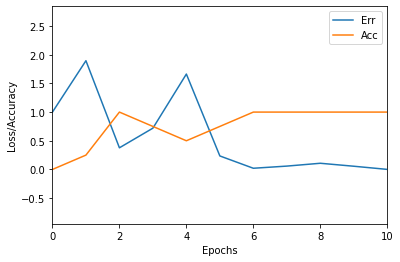

In [7]:
print("Ploting training loss ...")
plt.plot(errLoss, label="Err")
plt.plot(accLoss, label="Acc")
plt.xlim([0, len(errLoss)-1])
plt.legend(loc='upper right')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epochs')
plt.margins(0.5, 0.5)
plt.show()

**Testando o modelo:**

Com o conjunto de teste verificamos a performance que a rede alcança para predizer os respectivos rótulos.

In [8]:
print("Testing the model ...")
acc = model.evaluate(Xtest, Ytest, batch_size=batchSize)
#print(model.metrics_names)
print("\tTop-1 Accuracy: %f" % acc[1])

Testing the model ...
16/16 [==============================] - 2s 105ms/step - loss: 1.9270 - accuracy: 0.6280
	Top-1 Accuracy: 0.628000
